In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Ghost Batch Normalization Class

In [0]:

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        #print("batch norm")
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        #print("Ghost batch norm",num_features)
        super().__init__(num_features, **kw)
        #print("Ghost batch norm...1...",num_features)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


## Defining a Network capabale of having Batch Normalization or Ghost Batch Normalization

In [0]:
dropout_value = 0
class Net(nn.Module):

    def __init__(self,batch_normalization=False,ghost_batch_normalization=False):
        super(Net, self).__init__()
        self.do_bn = batch_normalization        
        self.do_ghost_bn = ghost_batch_normalization 


        self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 26, RF = 3
        if self.do_bn:
          self.conv1_bn = nn.BatchNorm2d(8) 
        elif self.do_ghost_bn:          
          self.conv1_ghost_bn = GhostBatchNorm(8,2)
                

        self.conv2 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0, bias=False), nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 24, RF = 5
        if self.do_bn:
          self.conv2_bn = nn.BatchNorm2d(12) 
        elif self.do_ghost_bn:          
          self.conv2_ghost_bn = GhostBatchNorm(12,2)             


        self.conv3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),nn.Conv2d(12, 8, 1, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 12, RF = 6
        if self.do_bn:   
          self.conv3_bn = nn.BatchNorm2d(8) 
        elif self.do_ghost_bn:          
          self.conv3_ghost_bn = GhostBatchNorm(8,2)              


        self.conv4 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0, bias=False),nn.ReLU(inplace=True), nn.Dropout(dropout_value)) # output_size = 10, RF = 10
        if self.do_bn: 
          self.conv4_bn = nn.BatchNorm2d(12)
        elif self.do_ghost_bn:          
          self.conv4_ghost_bn = GhostBatchNorm(12,2)             


        self.conv5 = nn.Sequential(nn.Conv2d(12, 16, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 8, RF = 14
        if self.do_bn:
          self.conv5_bn = nn.BatchNorm2d(16)
        elif self.do_ghost_bn:          
          self.conv5_ghost_bn = GhostBatchNorm(16,2)             


        self.conv6 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 6, RF = 18
        if self.do_bn:
          self.conv6_bn = nn.BatchNorm2d(32)
        elif self.do_ghost_bn:          
          self.conv6_ghost_bn = GhostBatchNorm(32,2)               


        self.gap = nn.AvgPool2d(kernel_size=6) # output_size = 1, RF = 28
        self.conv7 = nn.Sequential(nn.Conv2d(32, 10, 1, padding=0, bias=False)) # output_size = 1, RF = 28


    def forward(self, x):

        # Model with Batch Normalization
        if self.do_bn: 
          x = self.conv1(x)
          x = self.conv1_bn(x)          
          x = self.conv2(x)
          x = self.conv2_bn(x)   
          x = self.conv3(x)
          x = self.conv3_bn(x)   
          x = self.conv4(x)
          x = self.conv4_bn(x)
          x = self.conv5(x)
          x = self.conv5_bn(x)
          x = self.conv6(x)
          x = self.conv6_bn(x)

        # Model with Ghost Batch Normalization
        elif self.do_ghost_bn:

          x = self.conv1(x)
          x = self.conv1_ghost_bn(x)          
          x = self.conv2(x)
          x = self.conv2_ghost_bn(x)   
          x = self.conv3(x)
          x = self.conv3_ghost_bn(x)   
          x = self.conv4(x)
          x = self.conv4_ghost_bn(x)
          x = self.conv5(x)
          x = self.conv5_ghost_bn(x)
          x = self.conv6(x)
          x = self.conv6_ghost_bn(x)

        else:
          x = self.conv1(x)
          x = self.conv2(x)
          x = self.conv3(x)
          x = self.conv4(x)
          x = self.conv5(x)
          x = self.conv6(x)
            

        x = self.gap(x)
        x = self.conv7(x)
        x = x.view(-1, 10)

        return F.log_softmax(x)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(batch_normalization=True,ghost_batch_normalization=False).to(device)
model2=Net(batch_normalization=False,ghost_batch_normalization=True).to(device)
summary(model, input_size=(1, 28, 28))
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
           Dropout-3            [-1, 8, 26, 26]               0
       BatchNorm2d-4            [-1, 8, 26, 26]              16
            Conv2d-5           [-1, 12, 24, 24]             864
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              96
             ReLU-11            [-1, 8, 12, 12]               0
          Dropout-12            [-1, 8, 12, 12]               0
      BatchNorm2d-13            [-1, 8, 12, 12]              16
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [5]:
torch.manual_seed(1)
batch_size = 128            #Used for Batch Normalization Model
gosht_BN_batch_size = 64    #Used for Ghost Batch Normalization Model

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


#For Ghost Batch Normalization - different batch size
ghost_BN_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=gosht_BN_batch_size, shuffle=True, **kwargs)


ghost_BN_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=gosht_BN_batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
def train_eval(model, device, train_loader):
    model.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)

    print('\n\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
test_acc = []
train_acc = []
#final_test_results=[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    print("length of test dataset",len(test_loader.dataset))
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    #print("in Test...final losses",test_losses)
    #print("in Test...final accuracies",test_acc)
    final_test_results.append(test_losses)
    final_test_results.append(test_acc)
    
    return test_losses,test_acc

In [0]:
def l1_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for parameter in model.parameters():
      reg_loss += l1_crit(parameter, loss)
    factor = 0.00025
    loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    


In [9]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from torch.optim.lr_scheduler import StepLR

# Training for 25 Epocs 
EPOCHS = 25
for i in range(9):

  BN_model = Net(batch_normalization=True,ghost_batch_normalization=False).to(device)  #Batch Normalization Model
  GBN_model=Net(batch_normalization=False,ghost_batch_normalization=True).to(device)   #Ghost Batch Normalization Model
  test_losses = []
  test_acc = []
  final_test_results=[]

  for epoch in range(EPOCHS):
    if i == 0:
      print("CASE_1: without L1andL2 with BN")
      print("EPOCH:", epoch)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      train(BN_model, device, train_loader, optimizer, epoch)
      PATH = '/content/gdrive/My Drive/evab2_sess_6_model_without_l1_l2_BN.pt'
      torch.save(model, PATH)
      results1 = test(BN_model, device, test_loader)
      

    elif i == 1:
      print("CASE_2: without L1andL2 with GBN")
      print("EPOCH:", epoch)            
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      PATH = '/content/gdrive/My Drive/evab2_sess_6_model_without_l1_l2_GBN.pt'
      torch.save(GBN_model, PATH)
      results2 = test(GBN_model, device, ghost_BN_test_loader)
      
    elif i == 2:
      print("CASE_3: with L1 with BN")
      print("EPOCH:", epoch)   
      
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      l1_train(BN_model, device, train_loader, optimizer, epoch)
      results3 = test(BN_model, device, test_loader)

    elif i == 3:
      print("CASE_4: with L1 with GBN")
      print("EPOCH:", epoch)    
       
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      l1_train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      results4 = test(GBN_model, device, ghost_BN_test_loader)


    elif i == 4:
      print("CASE_5: with L2 with BN")
      print("EPOCH:", epoch)   
      
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      train(BN_model, device, train_loader, optimizer, epoch)
      results5 =test(BN_model, device, test_loader)

    elif i == 5:
      print("CASE_6: with L2 with GBN")
      print("EPOCH:", epoch)    
      
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      results6 =test(GBN_model, device, ghost_BN_test_loader)


    elif i ==6:
      print("CASE_7: with L1andL2 with BN")
      print("EPOCH:", epoch)     
      
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      l1_train(BN_model, device, train_loader, optimizer, epoch)
      results7 =test(BN_model, device, test_loader)    


    elif i ==7:
      print("CASE_8: with L1andL2 with GBN")
      print("EPOCH:", epoch)  
        
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      l1_train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      results8 =test(GBN_model, device, ghost_BN_test_loader)    



print(results1)
print(results2)
print(results3)
print(results4)
print(results5)
print(results6)
print(results7)
print(results8)

  0%|          | 0/469 [00:00<?, ?it/s]

CASE_1: without L1andL2 with BN
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.08767969161272049 Batch_id=468 Accuracy=89.08: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0871, Accuracy: 9767/10000 (97.67%)

CASE_1: without L1andL2 with BN
EPOCH: 1


Loss=0.04987098649144173 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9841/10000 (98.41%)

CASE_1: without L1andL2 with BN
EPOCH: 2


Loss=0.026324473321437836 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9872/10000 (98.72%)

CASE_1: without L1andL2 with BN
EPOCH: 3


Loss=0.10160580277442932 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9844/10000 (98.44%)

CASE_1: without L1andL2 with BN
EPOCH: 4


Loss=0.06113915517926216 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9853/10000 (98.53%)

CASE_1: without L1andL2 with BN
EPOCH: 5


Loss=0.016886988654732704 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9893/10000 (98.93%)

CASE_1: without L1andL2 with BN
EPOCH: 6


Loss=0.033589694648981094 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9903/10000 (99.03%)

CASE_1: without L1andL2 with BN
EPOCH: 7


Loss=0.00464041018858552 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9892/10000 (98.92%)

CASE_1: without L1andL2 with BN
EPOCH: 8


Loss=0.010003435425460339 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9911/10000 (99.11%)

CASE_1: without L1andL2 with BN
EPOCH: 9


Loss=0.014807109721004963 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9915/10000 (99.15%)

CASE_1: without L1andL2 with BN
EPOCH: 10


Loss=0.008563180454075336 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

CASE_1: without L1andL2 with BN
EPOCH: 11


Loss=0.06513188034296036 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

CASE_1: without L1andL2 with BN
EPOCH: 12


Loss=0.04239657521247864 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9913/10000 (99.13%)

CASE_1: without L1andL2 with BN
EPOCH: 13


Loss=0.01772659830749035 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.11%)

CASE_1: without L1andL2 with BN
EPOCH: 14


Loss=0.007963880896568298 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)

CASE_1: without L1andL2 with BN
EPOCH: 15


Loss=0.0036379348021000624 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9921/10000 (99.21%)

CASE_1: without L1andL2 with BN
EPOCH: 16


Loss=0.009434784762561321 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99.17%)

CASE_1: without L1andL2 with BN
EPOCH: 17


Loss=0.0775628313422203 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

CASE_1: without L1andL2 with BN
EPOCH: 18


Loss=0.0644412413239479 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99.20%)

CASE_1: without L1andL2 with BN
EPOCH: 19


Loss=0.0251015517860651 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

CASE_1: without L1andL2 with BN
EPOCH: 20


Loss=0.03119768761098385 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9915/10000 (99.15%)

CASE_1: without L1andL2 with BN
EPOCH: 21


Loss=0.007881487719714642 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

CASE_1: without L1andL2 with BN
EPOCH: 22


Loss=0.0484955869615078 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

CASE_1: without L1andL2 with BN
EPOCH: 23


Loss=0.062145840376615524 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

CASE_1: without L1andL2 with BN
EPOCH: 24


Loss=0.018679559230804443 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

CASE_2: without L1andL2 with GBN
EPOCH: 0


Loss=0.12290819734334946 Batch_id=937 Accuracy=92.48: 100%|██████████| 938/938 [00:26<00:00, 34.96it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type GhostBatchNorm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9836/10000 (98.36%)

CASE_2: without L1andL2 with GBN
EPOCH: 1


Loss=0.11736148595809937 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:26<00:00, 34.98it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9876/10000 (98.76%)

CASE_2: without L1andL2 with GBN
EPOCH: 2


Loss=0.08443707227706909 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:27<00:00, 34.49it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9899/10000 (98.99%)

CASE_2: without L1andL2 with GBN
EPOCH: 3


Loss=0.10739874094724655 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:26<00:00, 34.82it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9898/10000 (98.98%)

CASE_2: without L1andL2 with GBN
EPOCH: 4


Loss=0.05364319682121277 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:27<00:00, 34.23it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9898/10000 (98.98%)

CASE_2: without L1andL2 with GBN
EPOCH: 5


Loss=0.002712041139602661 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:27<00:00, 34.29it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)

CASE_2: without L1andL2 with GBN
EPOCH: 6


Loss=0.005312472581863403 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:27<00:00, 34.30it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9937/10000 (99.37%)

CASE_2: without L1andL2 with GBN
EPOCH: 7


Loss=0.01654958724975586 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

CASE_2: without L1andL2 with GBN
EPOCH: 8


Loss=0.007103174924850464 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:27<00:00, 34.65it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9919/10000 (99.19%)

CASE_2: without L1andL2 with GBN
EPOCH: 9


Loss=0.07129428535699844 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:27<00:00, 33.71it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)

CASE_2: without L1andL2 with GBN
EPOCH: 10


Loss=0.08012713491916656 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:27<00:00, 33.52it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

CASE_2: without L1andL2 with GBN
EPOCH: 11


Loss=0.012198075652122498 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:27<00:00, 33.55it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

CASE_2: without L1andL2 with GBN
EPOCH: 12


Loss=0.015973106026649475 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:28<00:00, 33.11it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

CASE_2: without L1andL2 with GBN
EPOCH: 13


Loss=0.00186920166015625 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:28<00:00, 33.28it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

CASE_2: without L1andL2 with GBN
EPOCH: 14


Loss=0.08102115988731384 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:28<00:00, 33.28it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9927/10000 (99.27%)

CASE_2: without L1andL2 with GBN
EPOCH: 15


Loss=0.002912759780883789 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:28<00:00, 33.31it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

CASE_2: without L1andL2 with GBN
EPOCH: 16


Loss=0.09495683014392853 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:28<00:00, 33.48it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

CASE_2: without L1andL2 with GBN
EPOCH: 17


Loss=0.025297001004219055 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:27<00:00, 33.53it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

CASE_2: without L1andL2 with GBN
EPOCH: 18


Loss=0.2501320242881775 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:28<00:00, 33.31it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9930/10000 (99.30%)

CASE_2: without L1andL2 with GBN
EPOCH: 19


Loss=0.030705168843269348 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:28<00:00, 33.46it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9930/10000 (99.30%)

CASE_2: without L1andL2 with GBN
EPOCH: 20


Loss=0.004064276814460754 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:28<00:00, 33.39it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

CASE_2: without L1andL2 with GBN
EPOCH: 21


Loss=0.4122542440891266 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:27<00:00, 33.57it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

CASE_2: without L1andL2 with GBN
EPOCH: 22


Loss=0.04432176053524017 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:28<00:00, 33.29it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9938/10000 (99.38%)

CASE_2: without L1andL2 with GBN
EPOCH: 23


Loss=0.05965752899646759 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:28<00:00, 33.28it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

CASE_2: without L1andL2 with GBN
EPOCH: 24


Loss=0.024285390973091125 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:28<00:00, 33.34it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

CASE_3: with L1 with BN
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) 

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9792/10000 (97.92%)

CASE_3: with L1 with BN
EPOCH: 1


Loss=0.26207882165908813 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9857/10000 (98.57%)

CASE_3: with L1 with BN
EPOCH: 2


Loss=0.34616637229919434 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9882/10000 (98.82%)

CASE_3: with L1 with BN
EPOCH: 3


Loss=0.1905839890241623 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9881/10000 (98.81%)

CASE_3: with L1 with BN
EPOCH: 4


Loss=0.18861444294452667 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

CASE_3: with L1 with BN
EPOCH: 5


Loss=0.3477119505405426 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9893/10000 (98.93%)

CASE_3: with L1 with BN
EPOCH: 6


Loss=0.33254218101501465 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9879/10000 (98.79%)

CASE_3: with L1 with BN
EPOCH: 7


Loss=0.19003665447235107 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9894/10000 (98.94%)

CASE_3: with L1 with BN
EPOCH: 8


Loss=0.17441275715827942 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9896/10000 (98.96%)

CASE_3: with L1 with BN
EPOCH: 9


Loss=0.2032228708267212 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9888/10000 (98.88%)

CASE_3: with L1 with BN
EPOCH: 10


Loss=0.230139821767807 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9903/10000 (99.03%)

CASE_3: with L1 with BN
EPOCH: 11


Loss=0.17360800504684448 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9892/10000 (98.92%)

CASE_3: with L1 with BN
EPOCH: 12


Loss=0.2032051682472229 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9896/10000 (98.96%)

CASE_3: with L1 with BN
EPOCH: 13


Loss=0.17148905992507935 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9914/10000 (99.14%)

CASE_3: with L1 with BN
EPOCH: 14


Loss=0.1796930730342865 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9917/10000 (99.17%)

CASE_3: with L1 with BN
EPOCH: 15


Loss=0.16297678649425507 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9895/10000 (98.95%)

CASE_3: with L1 with BN
EPOCH: 16


Loss=0.16996490955352783 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9910/10000 (99.10%)

CASE_3: with L1 with BN
EPOCH: 17


Loss=0.27736327052116394 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9916/10000 (99.16%)

CASE_3: with L1 with BN
EPOCH: 18


Loss=0.21394288539886475 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9931/10000 (99.31%)

CASE_3: with L1 with BN
EPOCH: 19


Loss=0.1688273847103119 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9876/10000 (98.76%)

CASE_3: with L1 with BN
EPOCH: 20


Loss=0.2750740945339203 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9917/10000 (99.17%)

CASE_3: with L1 with BN
EPOCH: 21


Loss=0.19890011847019196 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9895/10000 (98.95%)

CASE_3: with L1 with BN
EPOCH: 22


Loss=0.19346101582050323 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)

CASE_3: with L1 with BN
EPOCH: 23


Loss=0.16253891587257385 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)

CASE_3: with L1 with BN
EPOCH: 24


Loss=0.21135127544403076 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9931/10000 (99.31%)

CASE_4: with L1 with GBN
EPOCH: 0


Loss=0.3663891553878784 Batch_id=937 Accuracy=94.36: 100%|██████████| 938/938 [00:33<00:00, 27.89it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9863/10000 (98.63%)

CASE_4: with L1 with GBN
EPOCH: 1


Loss=0.21341101825237274 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:33<00:00, 27.70it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9861/10000 (98.61%)

CASE_4: with L1 with GBN
EPOCH: 2


Loss=0.4933035373687744 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:33<00:00, 27.91it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9889/10000 (98.89%)

CASE_4: with L1 with GBN
EPOCH: 3


Loss=0.3119969964027405 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:33<00:00, 27.92it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9898/10000 (98.98%)

CASE_4: with L1 with GBN
EPOCH: 4


Loss=0.21272745728492737 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:33<00:00, 27.97it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9915/10000 (99.15%)

CASE_4: with L1 with GBN
EPOCH: 5


Loss=0.2092190682888031 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:33<00:00, 28.23it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9923/10000 (99.23%)

CASE_4: with L1 with GBN
EPOCH: 6


Loss=0.43818342685699463 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:33<00:00, 28.05it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9888/10000 (98.88%)

CASE_4: with L1 with GBN
EPOCH: 7


Loss=0.1988157331943512 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:33<00:00, 28.21it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9879/10000 (98.79%)

CASE_4: with L1 with GBN
EPOCH: 8


Loss=0.1926741898059845 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:33<00:00, 28.17it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

CASE_4: with L1 with GBN
EPOCH: 9


Loss=0.32630085945129395 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:33<00:00, 28.02it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9837/10000 (98.37%)

CASE_4: with L1 with GBN
EPOCH: 10


Loss=0.2735273241996765 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:33<00:00, 28.16it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9896/10000 (98.96%)

CASE_4: with L1 with GBN
EPOCH: 11


Loss=0.21132977306842804 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:33<00:00, 28.24it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9916/10000 (99.16%)

CASE_4: with L1 with GBN
EPOCH: 12


Loss=0.5764740705490112 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:33<00:00, 28.13it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9900/10000 (99.00%)

CASE_4: with L1 with GBN
EPOCH: 13


Loss=0.27888941764831543 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:33<00:00, 28.16it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9898/10000 (98.98%)

CASE_4: with L1 with GBN
EPOCH: 14


Loss=0.19268901646137238 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:33<00:00, 28.14it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9909/10000 (99.09%)

CASE_4: with L1 with GBN
EPOCH: 15


Loss=0.26249849796295166 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:33<00:00, 28.28it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

CASE_4: with L1 with GBN
EPOCH: 16


Loss=0.249604269862175 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:33<00:00, 28.02it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)

CASE_4: with L1 with GBN
EPOCH: 17


Loss=0.25256264209747314 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:33<00:00, 28.06it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9912/10000 (99.12%)

CASE_4: with L1 with GBN
EPOCH: 18


Loss=0.528182864189148 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:33<00:00, 27.90it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9905/10000 (99.05%)

CASE_4: with L1 with GBN
EPOCH: 19


Loss=0.18056313693523407 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:33<00:00, 28.08it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

CASE_4: with L1 with GBN
EPOCH: 20


Loss=0.18125298619270325 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:33<00:00, 28.05it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

CASE_4: with L1 with GBN
EPOCH: 21


Loss=0.5637269020080566 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:33<00:00, 27.96it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9892/10000 (98.92%)

CASE_4: with L1 with GBN
EPOCH: 22


Loss=0.18065145611763 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:33<00:00, 27.96it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

CASE_4: with L1 with GBN
EPOCH: 23


Loss=0.2209283709526062 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:33<00:00, 28.09it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9896/10000 (98.96%)

CASE_4: with L1 with GBN
EPOCH: 24


Loss=0.2633742690086365 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:33<00:00, 28.14it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9895/10000 (98.95%)

CASE_5: with L2 with BN
EPOCH: 0


Loss=0.10702705383300781 Batch_id=468 Accuracy=88.12: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0885, Accuracy: 9769/10000 (97.69%)

CASE_5: with L2 with BN
EPOCH: 1


Loss=0.08605924993753433 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9824/10000 (98.24%)

CASE_5: with L2 with BN
EPOCH: 2


Loss=0.061201900243759155 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9883/10000 (98.83%)

CASE_5: with L2 with BN
EPOCH: 3


Loss=0.051636338233947754 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9885/10000 (98.85%)

CASE_5: with L2 with BN
EPOCH: 4


Loss=0.0739726796746254 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9886/10000 (98.86%)

CASE_5: with L2 with BN
EPOCH: 5


Loss=0.07324865460395813 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9879/10000 (98.79%)

CASE_5: with L2 with BN
EPOCH: 6


Loss=0.009962956421077251 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9892/10000 (98.92%)

CASE_5: with L2 with BN
EPOCH: 7


Loss=0.0322195403277874 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9902/10000 (99.02%)

CASE_5: with L2 with BN
EPOCH: 8


Loss=0.01929321698844433 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9895/10000 (98.95%)

CASE_5: with L2 with BN
EPOCH: 9


Loss=0.04746796190738678 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9913/10000 (99.13%)

CASE_5: with L2 with BN
EPOCH: 10


Loss=0.04110044240951538 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9930/10000 (99.30%)

CASE_5: with L2 with BN
EPOCH: 11


Loss=0.017985200509428978 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)

CASE_5: with L2 with BN
EPOCH: 12


Loss=0.020921185612678528 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9928/10000 (99.28%)

CASE_5: with L2 with BN
EPOCH: 13


Loss=0.019498338922858238 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9914/10000 (99.14%)

CASE_5: with L2 with BN
EPOCH: 14


Loss=0.007778927683830261 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

CASE_5: with L2 with BN
EPOCH: 15


Loss=0.00977759063243866 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

CASE_5: with L2 with BN
EPOCH: 16


Loss=0.023118257522583008 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9933/10000 (99.33%)

CASE_5: with L2 with BN
EPOCH: 17


Loss=0.0031628061551600695 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

CASE_5: with L2 with BN
EPOCH: 18


Loss=0.06167750433087349 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9928/10000 (99.28%)

CASE_5: with L2 with BN
EPOCH: 19


Loss=0.05027646943926811 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

CASE_5: with L2 with BN
EPOCH: 20


Loss=0.006919140461832285 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

CASE_5: with L2 with BN
EPOCH: 21


Loss=0.02340693771839142 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9910/10000 (99.10%)

CASE_5: with L2 with BN
EPOCH: 22


Loss=0.08031108230352402 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

CASE_5: with L2 with BN
EPOCH: 23


Loss=0.017748326063156128 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

CASE_5: with L2 with BN
EPOCH: 24


Loss=0.005047321319580078 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

CASE_6: with L2 with GBN
EPOCH: 0


Loss=0.031415924429893494 Batch_id=937 Accuracy=91.69: 100%|██████████| 938/938 [00:28<00:00, 32.54it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9842/10000 (98.42%)

CASE_6: with L2 with GBN
EPOCH: 1


Loss=0.09402687847614288 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:28<00:00, 32.71it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9888/10000 (98.88%)

CASE_6: with L2 with GBN
EPOCH: 2


Loss=0.07143551111221313 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:28<00:00, 32.57it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9895/10000 (98.95%)

CASE_6: with L2 with GBN
EPOCH: 3


Loss=0.0034630298614501953 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9899/10000 (98.99%)

CASE_6: with L2 with GBN
EPOCH: 4


Loss=0.02638782560825348 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:28<00:00, 32.61it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9907/10000 (99.07%)

CASE_6: with L2 with GBN
EPOCH: 5


Loss=0.02248808741569519 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:28<00:00, 32.60it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

CASE_6: with L2 with GBN
EPOCH: 6


Loss=0.01356351375579834 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:28<00:00, 32.94it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

CASE_6: with L2 with GBN
EPOCH: 7


Loss=0.003195658326148987 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:28<00:00, 32.84it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

CASE_6: with L2 with GBN
EPOCH: 8


Loss=0.034361906349658966 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:28<00:00, 32.97it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.11%)

CASE_6: with L2 with GBN
EPOCH: 9


Loss=0.11560868471860886 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:28<00:00, 32.88it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)

CASE_6: with L2 with GBN
EPOCH: 10


Loss=0.006127804517745972 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:28<00:00, 32.64it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

CASE_6: with L2 with GBN
EPOCH: 11


Loss=0.021937891840934753 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:28<00:00, 32.74it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

CASE_6: with L2 with GBN
EPOCH: 12


Loss=0.04748622328042984 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:28<00:00, 32.75it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

CASE_6: with L2 with GBN
EPOCH: 13


Loss=0.019612029194831848 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:28<00:00, 32.73it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

CASE_6: with L2 with GBN
EPOCH: 14


Loss=0.008085951209068298 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:28<00:00, 32.74it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

CASE_6: with L2 with GBN
EPOCH: 15


Loss=0.011124521493911743 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:28<00:00, 32.65it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9931/10000 (99.31%)

CASE_6: with L2 with GBN
EPOCH: 16


Loss=0.0055729299783706665 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:28<00:00, 32.78it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)

CASE_6: with L2 with GBN
EPOCH: 17


Loss=0.05008673667907715 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:28<00:00, 32.93it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

CASE_6: with L2 with GBN
EPOCH: 18


Loss=0.0042961835861206055 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:28<00:00, 32.89it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

CASE_6: with L2 with GBN
EPOCH: 19


Loss=0.008260637521743774 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:28<00:00, 32.78it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

CASE_6: with L2 with GBN
EPOCH: 20


Loss=0.0037123560905456543 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:28<00:00, 32.96it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

CASE_6: with L2 with GBN
EPOCH: 21


Loss=0.06841050088405609 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:28<00:00, 32.80it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

CASE_6: with L2 with GBN
EPOCH: 22


Loss=0.04788993299007416 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:28<00:00, 32.83it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

CASE_6: with L2 with GBN
EPOCH: 23


Loss=0.011753290891647339 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:28<00:00, 32.77it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

CASE_6: with L2 with GBN
EPOCH: 24


Loss=0.02574583888053894 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:28<00:00, 32.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

CASE_7: with L1andL2 with BN
EPOCH: 0


Loss=0.41280966997146606 Batch_id=468 Accuracy=92.55: 100%|██████████| 469/469 [00:24<00:00, 18.84it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0754, Accuracy: 9794/10000 (97.94%)

CASE_7: with L1andL2 with BN
EPOCH: 1


Loss=0.23358292877674103 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9851/10000 (98.51%)

CASE_7: with L1andL2 with BN
EPOCH: 2


Loss=0.1860780268907547 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9863/10000 (98.63%)

CASE_7: with L1andL2 with BN
EPOCH: 3


Loss=0.27566462755203247 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9902/10000 (99.02%)

CASE_7: with L1andL2 with BN
EPOCH: 4


Loss=0.18394117057323456 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9907/10000 (99.07%)

CASE_7: with L1andL2 with BN
EPOCH: 5


Loss=0.2715487778186798 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:25<00:00, 18.56it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9906/10000 (99.06%)

CASE_7: with L1andL2 with BN
EPOCH: 6


Loss=0.18270078301429749 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:25<00:00, 18.56it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

CASE_7: with L1andL2 with BN
EPOCH: 7


Loss=0.3240877687931061 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9884/10000 (98.84%)

CASE_7: with L1andL2 with BN
EPOCH: 8


Loss=0.3215101361274719 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9866/10000 (98.66%)

CASE_7: with L1andL2 with BN
EPOCH: 9


Loss=0.16860897839069366 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9900/10000 (99.00%)

CASE_7: with L1andL2 with BN
EPOCH: 10


Loss=0.16558362543582916 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9901/10000 (99.01%)

CASE_7: with L1andL2 with BN
EPOCH: 11


Loss=0.200633242726326 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9891/10000 (98.91%)

CASE_7: with L1andL2 with BN
EPOCH: 12


Loss=0.18991219997406006 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9873/10000 (98.73%)

CASE_7: with L1andL2 with BN
EPOCH: 13


Loss=0.18292534351348877 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9901/10000 (99.01%)

CASE_7: with L1andL2 with BN
EPOCH: 14


Loss=0.16604335606098175 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:25<00:00, 18.65it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9910/10000 (99.10%)

CASE_7: with L1andL2 with BN
EPOCH: 15


Loss=0.15993203222751617 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9896/10000 (98.96%)

CASE_7: with L1andL2 with BN
EPOCH: 16


Loss=0.19879549741744995 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:25<00:00, 18.59it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9907/10000 (99.07%)

CASE_7: with L1andL2 with BN
EPOCH: 17


Loss=0.1672006994485855 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9905/10000 (99.05%)

CASE_7: with L1andL2 with BN
EPOCH: 18


Loss=0.1871592104434967 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

CASE_7: with L1andL2 with BN
EPOCH: 19


Loss=0.1564781218767166 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9905/10000 (99.05%)

CASE_7: with L1andL2 with BN
EPOCH: 20


Loss=0.22294633090496063 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9908/10000 (99.08%)

CASE_7: with L1andL2 with BN
EPOCH: 21


Loss=0.15812277793884277 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9880/10000 (98.80%)

CASE_7: with L1andL2 with BN
EPOCH: 22


Loss=0.15442022681236267 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9887/10000 (98.87%)

CASE_7: with L1andL2 with BN
EPOCH: 23


Loss=0.17078937590122223 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:25<00:00, 18.18it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)

CASE_7: with L1andL2 with BN
EPOCH: 24


Loss=0.24739323556423187 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9885/10000 (98.85%)

CASE_8: with L1andL2 with GBN
EPOCH: 0


Loss=0.6835427284240723 Batch_id=937 Accuracy=94.36: 100%|██████████| 938/938 [00:34<00:00, 27.05it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9862/10000 (98.62%)

CASE_8: with L1andL2 with GBN
EPOCH: 1


Loss=0.22110335528850555 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:34<00:00, 27.27it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9859/10000 (98.59%)

CASE_8: with L1andL2 with GBN
EPOCH: 2


Loss=0.2121676504611969 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:34<00:00, 27.22it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9907/10000 (99.07%)

CASE_8: with L1andL2 with GBN
EPOCH: 3


Loss=0.2098132073879242 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:34<00:00, 27.38it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

CASE_8: with L1andL2 with GBN
EPOCH: 4


Loss=0.2768900990486145 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:34<00:00, 27.41it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9870/10000 (98.70%)

CASE_8: with L1andL2 with GBN
EPOCH: 5


Loss=0.39445632696151733 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:34<00:00, 27.18it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9885/10000 (98.85%)

CASE_8: with L1andL2 with GBN
EPOCH: 6


Loss=0.5514515042304993 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:34<00:00, 26.99it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9900/10000 (99.00%)

CASE_8: with L1andL2 with GBN
EPOCH: 7


Loss=0.19103528559207916 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:34<00:00, 27.10it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)

CASE_8: with L1andL2 with GBN
EPOCH: 8


Loss=0.20841971039772034 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:34<00:00, 27.04it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9907/10000 (99.07%)

CASE_8: with L1andL2 with GBN
EPOCH: 9


Loss=0.19149786233901978 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:34<00:00, 27.31it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9892/10000 (98.92%)

CASE_8: with L1andL2 with GBN
EPOCH: 10


Loss=0.1895047426223755 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:34<00:00, 27.40it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9895/10000 (98.95%)

CASE_8: with L1andL2 with GBN
EPOCH: 11


Loss=0.22385987639427185 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:34<00:00, 27.23it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9901/10000 (99.01%)

CASE_8: with L1andL2 with GBN
EPOCH: 12


Loss=0.220345601439476 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:34<00:00, 27.09it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9923/10000 (99.23%)

CASE_8: with L1andL2 with GBN
EPOCH: 13


Loss=0.39412248134613037 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:34<00:00, 27.31it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

CASE_8: with L1andL2 with GBN
EPOCH: 14


Loss=0.19180987775325775 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:34<00:00, 27.46it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9893/10000 (98.93%)

CASE_8: with L1andL2 with GBN
EPOCH: 15


Loss=0.18464329838752747 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:34<00:00, 27.33it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9893/10000 (98.93%)

CASE_8: with L1andL2 with GBN
EPOCH: 16


Loss=0.1836780160665512 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:34<00:00, 27.20it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9907/10000 (99.07%)

CASE_8: with L1andL2 with GBN
EPOCH: 17


Loss=0.20013418793678284 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:34<00:00, 27.32it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9895/10000 (98.95%)

CASE_8: with L1andL2 with GBN
EPOCH: 18


Loss=0.19125482439994812 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:34<00:00, 27.54it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9900/10000 (99.00%)

CASE_8: with L1andL2 with GBN
EPOCH: 19


Loss=0.1836261749267578 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:34<00:00, 27.31it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

CASE_8: with L1andL2 with GBN
EPOCH: 20


Loss=0.33564645051956177 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:34<00:00, 27.25it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9898/10000 (98.98%)

CASE_8: with L1andL2 with GBN
EPOCH: 21


Loss=0.19221946597099304 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:34<00:00, 27.26it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99.16%)

CASE_8: with L1andL2 with GBN
EPOCH: 22


Loss=0.1933169960975647 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:34<00:00, 27.17it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

CASE_8: with L1andL2 with GBN
EPOCH: 23


Loss=0.1802830547094345 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:34<00:00, 27.33it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9913/10000 (99.13%)

CASE_8: with L1andL2 with GBN
EPOCH: 24


Loss=0.266417533159256 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:34<00:00, 27.25it/s]

length of test dataset 10000



Test set: Average loss: 0.0257, Accuracy: 9924/10000 (99.24%)

([0.08712051639556885, 0.05907927596569061, 0.047404966425895693, 0.04882053952217102, 0.047650689029693605, 0.03422458548545838, 0.0321043083190918, 0.03511861190795899, 0.02827782201766968, 0.026572900104522706, 0.0278937068939209, 0.027763124132156373, 0.027307709765434264, 0.028635341358184813, 0.02371158950328827, 0.02422921221256256, 0.024957914805412294, 0.023645932412147522, 0.02486011824607849, 0.022030610370635986, 0.024331530022621155, 0.02279934751987457, 0.02151139430999756, 0.024133358120918273, 0.024088851165771485], [97.67, 98.41, 98.72, 98.44, 98.53, 98.93, 99.03, 98.92, 99.11, 99.15, 99.14, 99.14, 99.13, 99.11, 99.3, 99.21, 99.17, 99.24, 99.2, 99.28, 99.15, 99.26, 99.35, 99.26, 99.22])
([0.06167624113559723, 0.04446468470096588, 0.036446965742111204, 0.029993217611312867, 0.030501646661758423, 0.02631999502182007, 0.023209322381019592, 0.024653010535240175, 0.02303713939189911, 0.021733572244644166, 0.022

In [0]:
print(results1)
print(results2)
print(results3)
print(results4)
print(results5)
print(results6)
print(results7)
print(results8)

([0.08712051639556885, 0.05907927596569061, 0.047404966425895693, 0.04882053952217102, 0.047650689029693605, 0.03422458548545838, 0.0321043083190918, 0.03511861190795899, 0.02827782201766968, 0.026572900104522706, 0.0278937068939209, 0.027763124132156373, 0.027307709765434264, 0.028635341358184813, 0.02371158950328827, 0.02422921221256256, 0.024957914805412294, 0.023645932412147522, 0.02486011824607849, 0.022030610370635986, 0.024331530022621155, 0.02279934751987457, 0.02151139430999756, 0.024133358120918273, 0.024088851165771485], [97.67, 98.41, 98.72, 98.44, 98.53, 98.93, 99.03, 98.92, 99.11, 99.15, 99.14, 99.14, 99.13, 99.11, 99.3, 99.21, 99.17, 99.24, 99.2, 99.28, 99.15, 99.26, 99.35, 99.26, 99.22])
([0.06167624113559723, 0.04446468470096588, 0.036446965742111204, 0.029993217611312867, 0.030501646661758423, 0.02631999502182007, 0.023209322381019592, 0.024653010535240175, 0.02303713939189911, 0.021733572244644166, 0.022154911518096922, 0.02318806872367859, 0.021394786524772644, 0.02

In [0]:
results1=([0.08712051639556885, 0.05907927596569061, 0.047404966425895693, 0.04882053952217102, 0.047650689029693605, 0.03422458548545838, 0.0321043083190918, 0.03511861190795899, 0.02827782201766968, 0.026572900104522706, 0.0278937068939209, 0.027763124132156373, 0.027307709765434264, 0.028635341358184813, 0.02371158950328827, 0.02422921221256256, 0.024957914805412294, 0.023645932412147522, 0.02486011824607849, 0.022030610370635986, 0.024331530022621155, 0.02279934751987457, 0.02151139430999756, 0.024133358120918273, 0.024088851165771485], [97.67, 98.41, 98.72, 98.44, 98.53, 98.93, 99.03, 98.92, 99.11, 99.15, 99.14, 99.14, 99.13, 99.11, 99.3, 99.21, 99.17, 99.24, 99.2, 99.28, 99.15, 99.26, 99.35, 99.26, 99.22])
results2=([0.06167624113559723, 0.04446468470096588, 0.036446965742111204, 0.029993217611312867, 0.030501646661758423, 0.02631999502182007, 0.023209322381019592, 0.024653010535240175, 0.02303713939189911, 0.021733572244644166, 0.022154911518096922, 0.02318806872367859, 0.021394786524772644, 0.02086892330646515, 0.022147082901000977, 0.018292997932434083, 0.020003550934791565, 0.018942557859420776, 0.019744516181945802, 0.021814876317977905, 0.019283751583099366, 0.019683881616592406, 0.017667436861991882, 0.018793130278587342, 0.020623895430564882], [98.36, 98.76, 98.99, 98.98, 98.98, 99.21, 99.37, 99.22, 99.19, 99.29, 99.33, 99.31, 99.26, 99.36, 99.27, 99.4, 99.29, 99.41, 99.3, 99.3, 99.43, 99.36, 99.38, 99.4, 99.34])
results3=([0.07018242197036743, 0.04716984829902649, 0.03724465169906616, 0.04018350875377655, 0.030681876611709596, 0.03510703353881836, 0.03757813568115234, 0.033070576548576355, 0.034975915694236755, 0.037987210202217105, 0.032580416536331175, 0.036320688819885254, 0.03205277507305145, 0.03041774191856384, 0.032548763608932496, 0.03491637945175171, 0.03191003136634827, 0.030328091406822206, 0.02405675799846649, 0.03995635876655579, 0.0279062926530838, 0.03418238661289215, 0.028518298387527466, 0.024750634980201722, 0.025040671133995055], [97.92, 98.57, 98.82, 98.81, 99.02, 98.93, 98.79, 98.94, 98.96, 98.88, 99.03, 98.92, 98.96, 99.14, 99.17, 98.95, 99.1, 99.16, 99.31, 98.76, 99.17, 98.95, 99.12, 99.24, 99.31])
results4=([0.04873356230258942, 0.04822146737575531, 0.04029549477100372, 0.03489876956939697, 0.03036963555812836, 0.029727819871902466, 0.03503506543636322, 0.0375765026807785, 0.030919742226600648, 0.053932340037822726, 0.03243062126636505, 0.02798608057498932, 0.03266340789794922, 0.03194479823112488, 0.030352529430389404, 0.02405307641029358, 0.026247403836250304, 0.03238119652271271, 0.03161728926897049, 0.028703784227371215, 0.027153801834583283, 0.03477689173221588, 0.029376200294494628, 0.035487415182590486, 0.03092079255580902], [98.63, 98.61, 98.89, 98.98, 99.15, 99.23, 98.88, 98.79, 99.03, 98.37, 98.96, 99.16, 99.0, 98.98, 99.09, 99.25, 99.16, 99.12, 99.05, 99.15, 99.22, 98.92, 99.08, 98.96, 98.95])
results5=([0.0884689875125885, 0.0632877099275589, 0.04767235910892487, 0.03716625473499298, 0.037152113151550294, 0.03898906762599945, 0.037856534647941587, 0.032948680138587955, 0.031045369601249696, 0.030212320494651796, 0.025187113785743714, 0.026456105637550353, 0.025203020787239076, 0.025651810336112975, 0.023821288442611693, 0.02395209250450134, 0.02355878083705902, 0.022996031594276427, 0.0246187358379364, 0.022777853083610536, 0.02354462375640869, 0.02841809844970703, 0.02369302611351013, 0.02188418607711792, 0.02253175904750824], [97.69, 98.24, 98.83, 98.85, 98.86, 98.79, 98.92, 99.02, 98.95, 99.13, 99.3, 99.21, 99.28, 99.14, 99.33, 99.28, 99.33, 99.31, 99.28, 99.28, 99.25, 99.1, 99.26, 99.33, 99.32])
results6=([0.05465448694229126, 0.039795475149154665, 0.03462353179454804, 0.03200745780467987, 0.03085509698390961, 0.028268775868415832, 0.02505081696510315, 0.025065526819229127, 0.028637975335121156, 0.02577780337333679, 0.02386323289871216, 0.023394082927703858, 0.02596871213912964, 0.024134507751464845, 0.02219335777759552, 0.023723670172691346, 0.02240776445865631, 0.022829526948928834, 0.02106082615852356, 0.020853206038475038, 0.02132769618034363, 0.020951562023162843, 0.019882465481758118, 0.020484441947937013, 0.020725257802009584], [98.42, 98.88, 98.95, 98.99, 99.07, 99.17, 99.23, 99.2, 99.11, 99.2, 99.21, 99.27, 99.21, 99.29, 99.24, 99.31, 99.35, 99.28, 99.33, 99.31, 99.32, 99.29, 99.38, 99.36, 99.3])
results7=([0.07535620303153992, 0.049125962615013126, 0.04528650004863739, 0.03324744791984558, 0.03284518792629242, 0.031762449193000794, 0.029429923510551452, 0.03801021857261658, 0.042935689902305604, 0.03754967606067657, 0.033849186253547665, 0.03386458127498627, 0.03891144571304321, 0.030595465433597566, 0.028697568941116334, 0.03027211034297943, 0.028827771162986755, 0.030098692297935485, 0.03179611072540283, 0.029312058997154236, 0.0276599746465683, 0.03730558023452759, 0.03653971000909805, 0.028856577587127685, 0.0342190434217453], [97.94, 98.51, 98.63, 99.02, 99.07, 99.06, 99.08, 98.84, 98.66, 99.0, 99.01, 98.91, 98.73, 99.01, 99.1, 98.96, 99.07, 99.05, 98.94, 99.05, 99.08, 98.8, 98.87, 99.15, 98.85])
results8=([0.04498333694934845, 0.042128240537643434, 0.034284064269065856, 0.027377631998062132, 0.04142796125411987, 0.03698693814277649, 0.03256377115249634, 0.03541636893749237, 0.0313881694316864, 0.03480311707258225, 0.03312363929748535, 0.03204542067050934, 0.027801942634582518, 0.03352891602516175, 0.03407773606777191, 0.03640471184253693, 0.02958036139011383, 0.03333224831819534, 0.02884473919868469, 0.028857432687282563, 0.033970660257339476, 0.02720959930419922, 0.030919905948638915, 0.027105154919624327, 0.02572360496520996], [98.62, 98.59, 99.07, 99.09, 98.7, 98.85, 99.0, 98.94, 99.07, 98.92, 98.95, 99.01, 99.23, 98.97, 98.93, 98.93, 99.07, 98.95, 99.0, 99.07, 98.98, 99.16, 99.02, 99.13, 99.24])

CASE_1: without L1andL2 with BN
CASE_2: without L1andL2 with GBN
CASE_3: with L1 with BN
CASE_4: with L1 with GBN
CASE_5: with L2 with BN
CASE_6: with L2 with GBN
CASE_7: with L1andL2 with BN
CASE_8: with L1andL2 with GBN


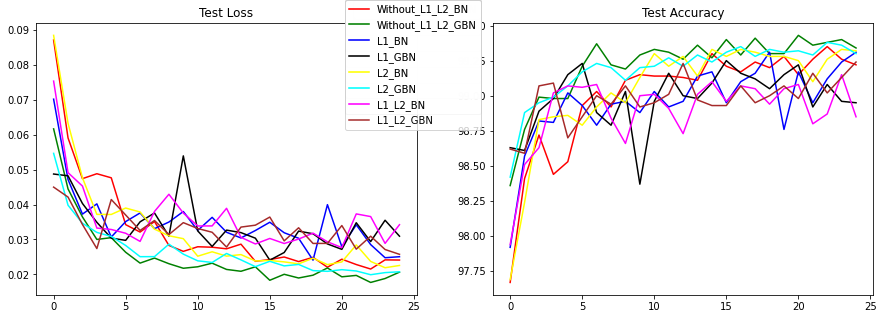

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
for i in range(1,9):
  if i == 1:
    print("CASE_1: without L1andL2 with BN")

    axs[0].plot(results1[0],color='red',label='Without_L1_L2_BN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results1[1],color='red')
    axs[1].set_title("Test Accuracy")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 2:
    print("CASE_2: without L1andL2 with GBN")
    
    axs[0].plot(results2[0],color='green',label='Without_L1_L2_GBN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results2[1],color='green')
    axs[1].set_title("Test Accuracy")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 3:
    print("CASE_3: with L1 with BN")
    
    axs[0].plot(results3[0],color='blue',label='L1_BN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results3[1],color='blue')
    axs[1].set_title("Test Accuracy123")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 4:
    print("CASE_4: with L1 with GBN")
    
    axs[0].plot(results4[0], color='black',label='L1_GBN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results4[1], color='black')
    axs[1].set_title("Test Accuracy")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 5:
    print("CASE_5: with L2 with BN")
    
    axs[0].plot(results5[0], color='yellow',label='L2_BN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results5[1], color='yellow')
    axs[1].set_title("Test Accuracy")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 6:
    print("CASE_6: with L2 with GBN")
    
    axs[0].plot(results6[0], color='cyan',label='L2_GBN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results6[1], color='cyan')
    axs[1].set_title("Test Accuracy")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 7:
    print("CASE_7: with L1andL2 with BN")
    
    axs[0].plot(results7[0], color='magenta',label='L1_L2_BN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results7[1], color='magenta')
    axs[1].set_title("Test Accuracy")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 8:
    print("CASE_8: with L1andL2 with GBN")
    
    axs[0].plot(results8[0], color='brown',label='L1_L2_GBN')
    axs[0].set_title("Test Loss")
    axs[1].plot(results8[1], color='brown')
    axs[1].set_title("Test Accuracy")
    fig.legend(loc='upper right',bbox_to_anchor=(0.45, 0.9))
    
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

In [0]:
model_without_l1_l2_BN = torch.load('/content/gdrive/My Drive/evab2_sess_6_model_without_l1_l2_BN.pt')

## Display 25 misclassified images of model without L1 and L2 Regularization along with BN

In [12]:
incorrect_image_list =[]
predicted_label_list =[]
correct_label_list = []
for (i, [data, target]) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model_without_l1_l2_BN(data)
    pred = output.argmax(dim=1, keepdim=True).squeeze(1)         
    idxs_mask = (pred !=  target).view(-1)
    img_nm = data[idxs_mask].cpu().numpy()
    img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
    if img_nm.shape[0] > 0:
        img_list = [img_nm[i] for i in range(img_nm.shape[0])]
        incorrect_image_list.extend(img_list)
        predicted_label_list.extend(pred[idxs_mask].cpu().numpy())
        correct_label_list.extend(target[idxs_mask].cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


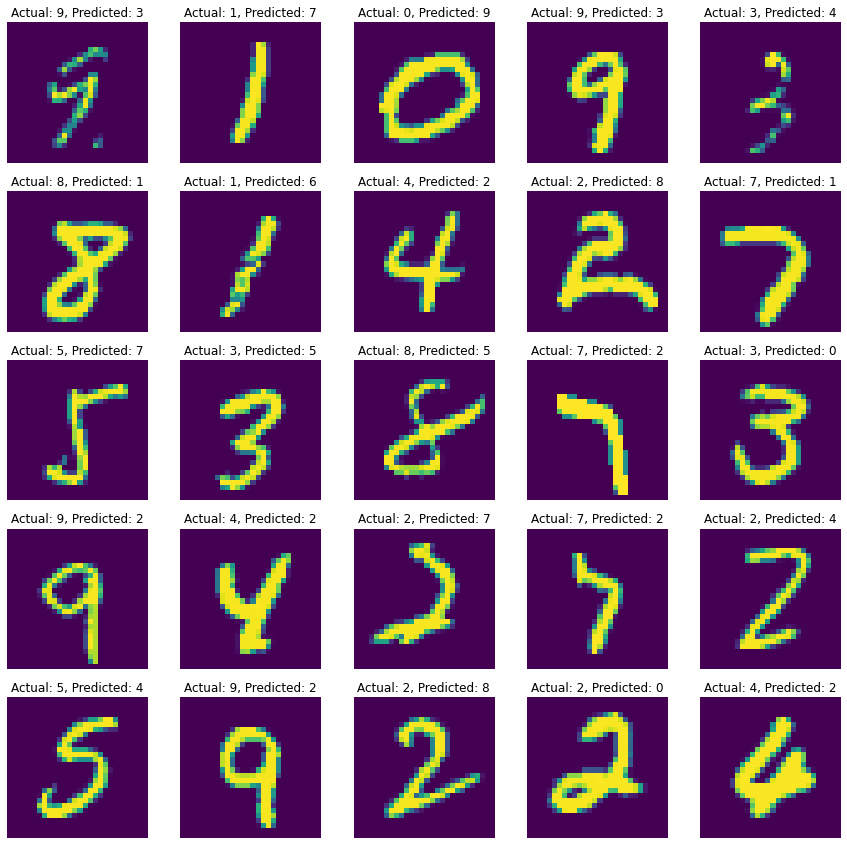

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
columns = 5
i= 0
# Display the list of 25 misclassified images
for index, image in enumerate(incorrect_image_list) :
    ax = plt.subplot(5, 5, i+1)
    ax.set_title("Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
    ax.axis('off')
    plt.imshow(image)
    i +=1
    if i==25:
        break

In [0]:
model_without_l1_l2_GBN = torch.load('/content/gdrive/My Drive/evab2_sess_6_model_without_l1_l2_GBN.pt')

## Display misclassified images of model without L1 and L2 Regularization along with GBN

In [16]:
incorrect_image_list =[]
predicted_label_list =[]
correct_label_list = []
for (i, [data, target]) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model_without_l1_l2_GBN(data)
    pred = output.argmax(dim=1, keepdim=True).squeeze(1)         
    idxs_mask = (pred !=  target).view(-1)
    img_nm = data[idxs_mask].cpu().numpy()
    img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
    if img_nm.shape[0] > 0:
        img_list = [img_nm[i] for i in range(img_nm.shape[0])]
        incorrect_image_list.extend(img_list)
        predicted_label_list.extend(pred[idxs_mask].cpu().numpy())
        correct_label_list.extend(target[idxs_mask].cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


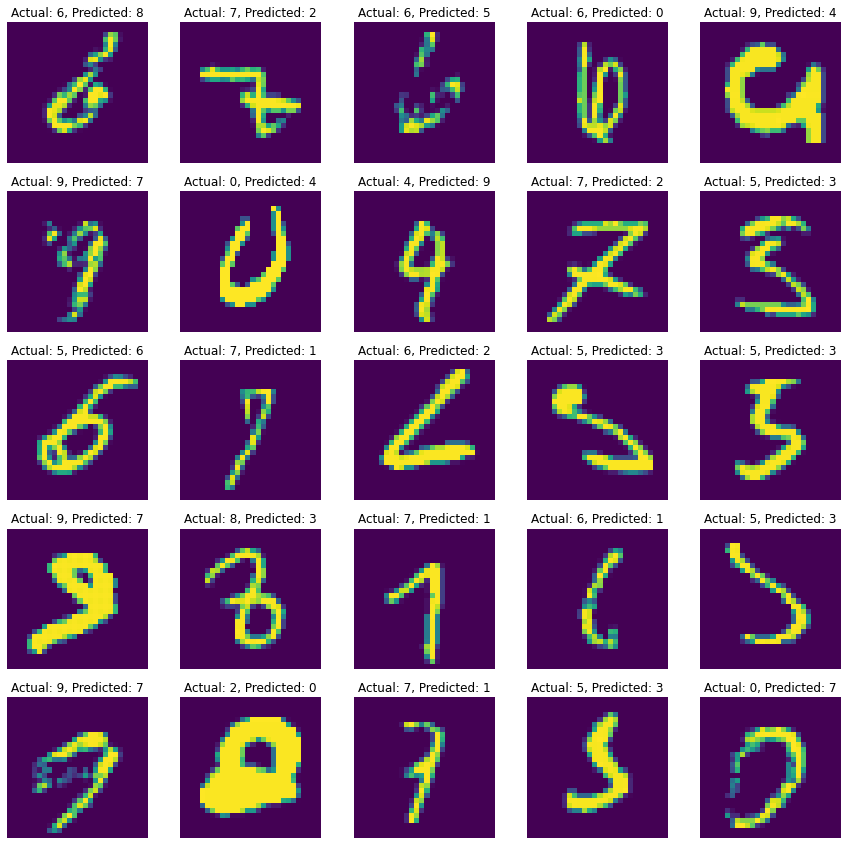

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
columns = 5
i= 0
# Display the list of 25 misclassified images
for index, image in enumerate(incorrect_image_list) :
    ax = plt.subplot(5, 5, i+1)
    ax.set_title("Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
    ax.axis('off')
    plt.imshow(image)
    i +=1
    if i==25:
        break